In this lab the VKontakte network was analyzed and a power law fitting model was constructed.

First of all the graph should be loaded and some of the descriptive statistics for the network computed.

In [1]:
import urllib
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

url = "https://dl.dropboxusercontent.com/s/q9geru5vtmz5b55/vk.adjlist?dl=1"
with urllib.request.urlopen(url) as f:
    data = f.read().decode('utf-8')
with open('vk.adjlist', 'w') as f:
    f.write(data) 
    
G = nx.read_adjlist('vk.adjlist')

In [2]:
print('Number of vertices:', G.number_of_nodes())
print('Number of edges:', G.number_of_edges())
print('Number of connected components', nx.number_connected_components(G))

Number of vertices: 2113
Number of edges: 25737
Number of connected components 1


Now let's compute and visualize degree distribution of the network:

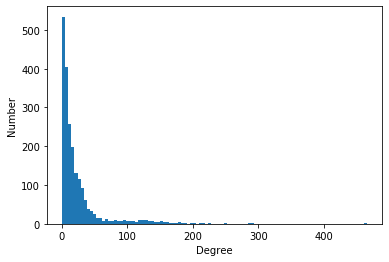

In [3]:
degrees_dictionary = dict(G.degree())
degrees = np.array(list(dict(G.degree()).values()))

# show node degrees
plt.xlabel('Degree')
plt.ylabel('Number')
plt.hist(degrees, 100)
plt.show()

Given the histogram above one can make a conclusion that the network satisfies Power Law.

To compute radius, diameter and the shortest path distribution of the graph it seems pointless to use the whole original graph because of its big size (in fact we couldn't use the original graph to compute the radius and the diameter because there are 10 connected components, so the graph itself is not connected).

To compute the shortest path distribution one need to obtain a represatative sample from the original network. To get a sample I generated a set of random indices within the largest connected components and then picked out corresponding nodes to the subgraph.

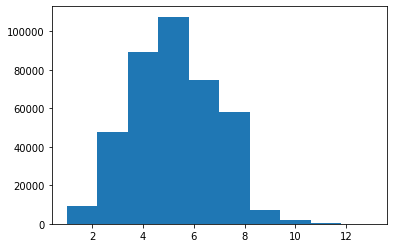

In [4]:
CC = sorted(nx.connected_components(G), key = len, reverse=True)

import random
cc0 = np.array(list(CC[0]))
subG = G.subgraph(np.random.choice(cc0, 1000))

shortest_paths = nx.shortest_path(subG)
lengths = []
for target, paths in shortest_paths.items():
    for k, value in paths.items():
        lengths.append(len(value))

plt.hist(lengths, 10)
plt.show()

Now let's compute max and mean degrees in the graph (since graph is undirected in-degrees and out-degrees coincide).

In [5]:
print('Max degree:', max(degrees))
print('Mean degree', np.mean(degrees))

Max degree: 465
Mean degree 24.36062470421202


And now it's time to estimate the value of $\alpha$ and error $\sigma ^2$(via Maximum Likelihood)

First of all let's look at the initial data. The graph below clearly indicates that there's no linear model to fit all the data. But starting from some degree data seems to follow linear pattern good enough. Following lectures I'll call the minimum degree for which data can be approximate by linear function $x_{min}$

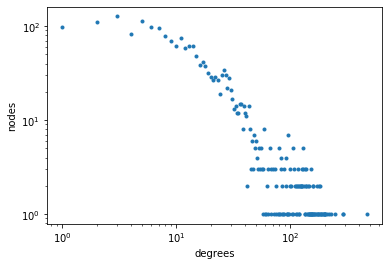

In [53]:
from collections import Counter
d = Counter(degrees)
plt.xlabel('degrees')
plt.ylabel('nodes')
plt.loglog(list(d.keys()), list(d.values()), '.', lw=2)
plt.show()

From the graph above one can obtain a rough value of the $x_{min}$, which is slightly more than 100.
To compute $\alpha$ and $\sigma^2$:

$\alpha = 1 + n (\sum ln( \frac{x_i}{x_{min}}))^{-1}$

$\sigma ^2 = \frac{\alpha - 1}{\sqrt{n}}$

In [63]:
x_min = 15.0
            
new_degrees = []
for degree in degrees:
    if degree >= x_min:
        new_degrees.append(degree)

n = len(new_degrees) + 0.0

alpha = 0.0
for degree in new_degrees:
    alpha = alpha + (np.log(degree / x_min))

alpha = 1 + n / alpha

alpha = get_alpha(x_min)
sigma = (alpha - 1) / np.sqrt(n)

print('Estimated alpha:', alpha)
print('and sigma squared:', sigma)

Estimated alpha: 2.167241161087035
and sigma squared: 0.03854569903371337


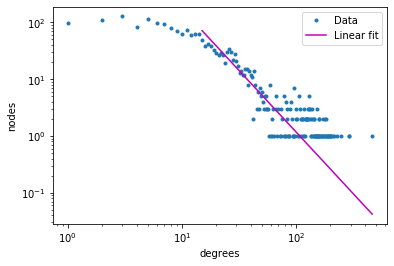

In [64]:
c = Counter(new_degrees)

C = (alpha - 1) * (x_min ** (alpha - 1))

def f(x):
    return C * (x ** (-alpha)) * n
x = np.arange(x_min, max(degrees), 1)

data, = plt.loglog(list(d.keys()), list(d.values()), '.', lw=2, label = 'Data')
fit,  = plt.loglog(x, f(x), 'm', label = 'Linear fit')
plt.xlabel('degrees')
plt.ylabel('nodes')
plt.legend(handles = [data, fit])
plt.show()

In [65]:
def get_alpha(x_min):
    new_degrees = []
    for degree in degrees:
        if degree >= x_min:
            new_degrees.append(degree)

    n = len(new_degrees) + 0.0
    
    alpha = 0.0
    for degree in new_degrees:
        alpha = alpha + (np.log(degree / x_min))

    alpha = 1 + n / alpha
    
    return alpha

Now it's time to estimate minimum degree using Kolmogorov-Smirnov test

In [68]:
# define functions to compute model and experimental CDFs

# to remind of one variable I calculated previously: d = Counter(degrees)
d_dict = dict(d)

def f_exp(x, x_min):
    result = 0.0
    N = 0.0
    for degree, nodes in d_dict.items():
        if degree >= x_min:
            N += nodes
            if degree <= x:
                result += nodes
    return result / N


def f_model(x, x_min, alpha):
    return 1 - (x / x_min) ** (1 - alpha)

In [73]:
# this is for plot D(x_min)
D_cords = dict()

def calculate_D(x_min):
    array = []
    alpha = get_alpha(x_min)
    for degree in d_dict.keys():
        if degree >= x_min:
            result = np.abs(f_model(degree, x_min, alpha) - f_exp(degree, x_min))
            array.append(result)
            D_cords[x_min] = result
    return max(array)

temp = dict()
for degree in d_dict.keys():
    if degree < 628:    
        temp[degree] = calculate_D(degree + 0.0)

/home/user/msTest/venv_jupyterhab/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


$x^*_{min} = argmin_{x_{min}}D$

In [74]:
real_x_min = min(temp,key=temp.get) + 0.0
print(real_x_min)

real_alpha = get_alpha(real_x_min)
real_C = (real_alpha - 1) * (real_x_min ** (real_alpha - 1))

19.0


PDF and CDF for obtained parameters:

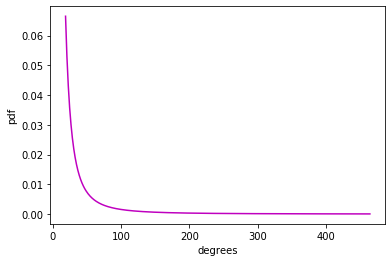

In [75]:
def pdf(x):
    return real_C * x ** (-real_alpha)
x = np.arange(real_x_min, max(degrees), 1)

plt.xlabel('degrees')
plt.ylabel('pdf')
plt.plot(x, pdf(x), 'm', label = 'PDF')
plt.show()

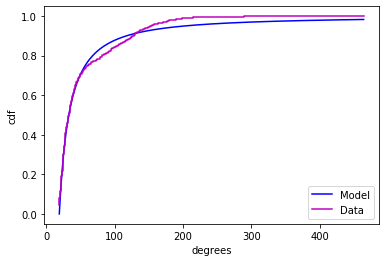

In [76]:
def cdf(x):
    return 1 - (x / real_x_min) ** (1 - real_alpha)

model, = plt.plot(x, cdf(x), 'b', label = 'Model')
y = []
for point in x:
    y.append(f_exp(point, real_x_min))
data,  = plt.step(x, y, 'm', label = 'Data')
plt.xlabel('degrees')
plt.ylabel('cdf')
plt.legend(handles = [model, data])
plt.show()